<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/Two_Way_Coupled_System_(Rule_30_CA_%2B_QW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.0 MB/s eta 0:00:00



===== Starting 1D Quantum Walk with TWO-WAY COUPLING to Rule 30 =====
Initialized 1D walker at site 25 in coin state |0> (index 50)

Starting 1D QW (Two-Way Coupled Rule 30 Coin, P_thresh=0.1, Feedback=flip) for 100 steps...
  Completed step 10/100
  Completed step 20/100
  Completed step 30/100
  Completed step 40/100
  Completed step 50/100
  Completed step 60/100
  Completed step 70/100
  Completed step 80/100
  Completed step 90/100
  Completed step 100/100
Evolution complete. Time: 0.16 seconds.

--- 1D QW (Two-Way Coupled Rule 30, P_thresh=0.1, Feedback='flip') Summary ---
N_sites=51, Depth=100, StartPos=25, StartCoin=0

Top 5 Final Probabilities (Site: Prob):
  Site 25: 0.15961
  Site 29: 0.11124
  Site 27: 0.10640
  Site 33: 0.10034
  Site 43: 0.09344

Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 50: S = 0.803458
  Step 100: S = 0.945595
--- End of Summary ---


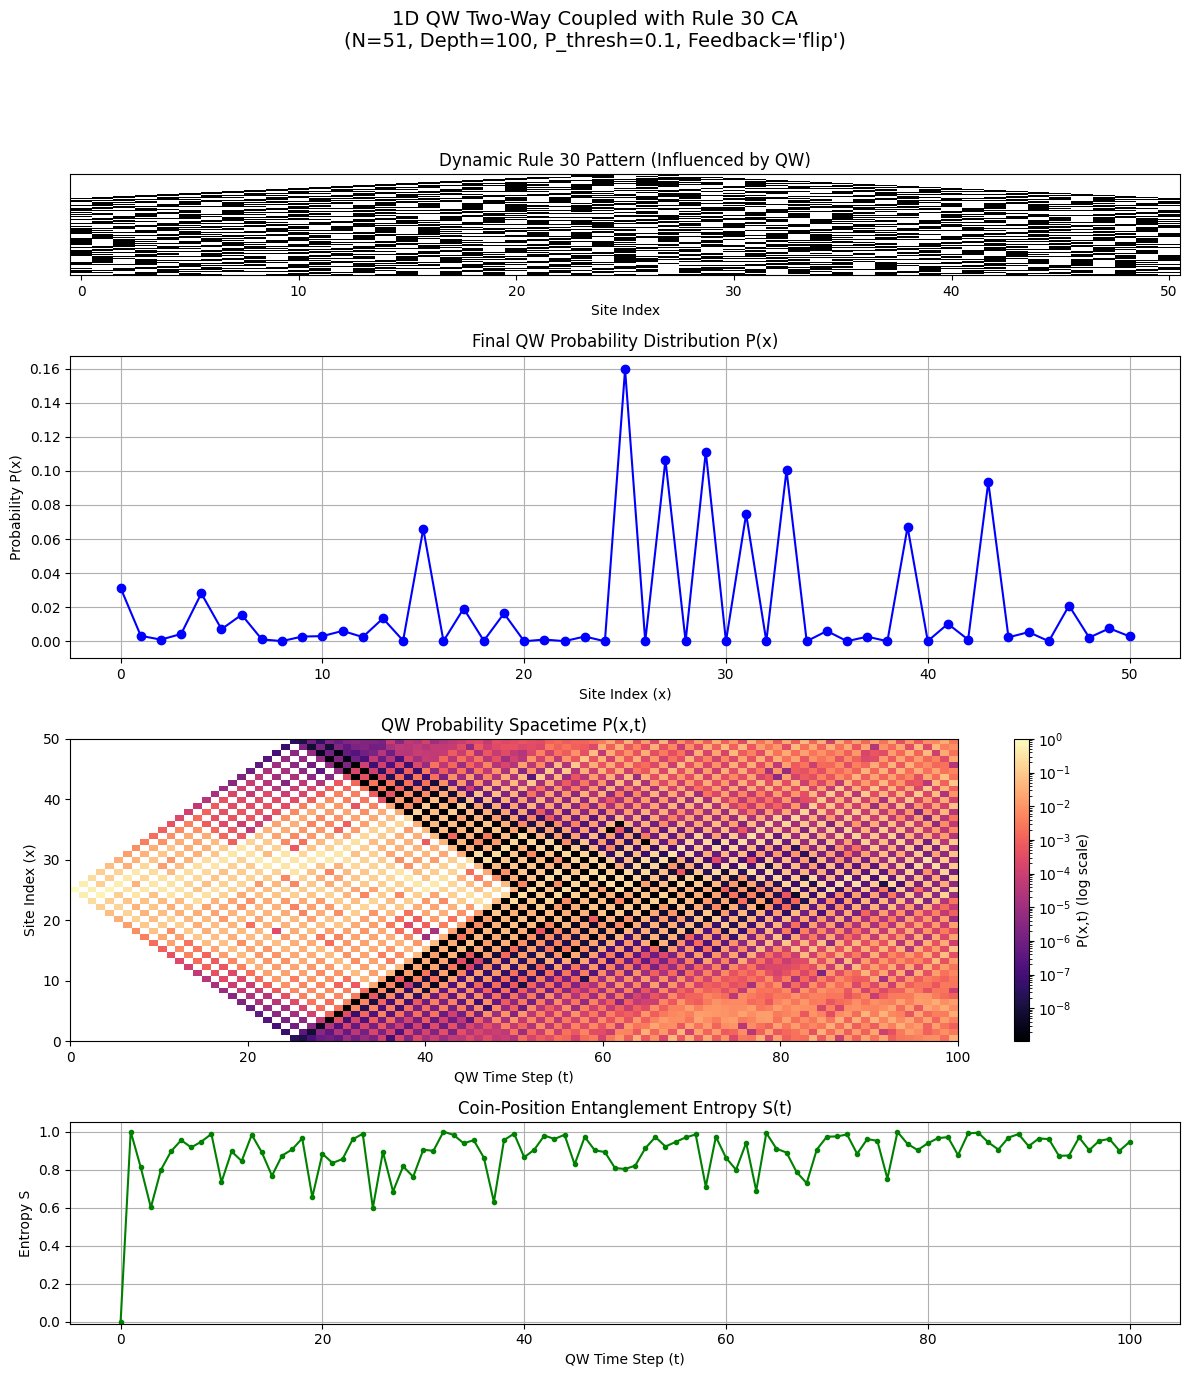

===== Finished 1D QW with Two-Way Coupled Rule 30 =====


<<<<< END OF 1D QW TWO-WAY COUPLING SIMULATION >>>>>


In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

# --- Parameters ---
N_SITES_1D = 51
DEPTH_1D = 100 # Let's reduce depth for initial tests of this complex system
INITIAL_POS_1D = N_SITES_1D // 2
INITIAL_COIN_1D = 0
INITIAL_CA_CENTER_ONE = True
CA_RULE_NUMBER = 30 # Start with Rule 30

# --- Two-Way Coupling Parameters ---
P_THRESHOLD = 0.1 # Probability threshold for QW to affect CA cell
FEEDBACK_TYPE = "flip" # Options: "flip", "set_to_one", "set_to_zero"

# --- CA Rule Update Function (Same as before) ---
def update_ca_line(current_line, rule_number):
    width = len(current_line)
    new_line = np.zeros(width, dtype=int)
    for i in range(width):
        prev_left = current_line[(i - 1 + width) % width]
        prev_center = current_line[i]
        prev_right = current_line[(i + 1) % width]
        pattern_val = (prev_left << 2) | (prev_center << 1) | prev_right
        if rule_number == 30:
            if pattern_val in [1, 2, 3, 4]: new_line[i] = 1
            else: new_line[i] = 0
        elif rule_number == 90:
            if prev_left != prev_right: new_line[i] = 1
            else: new_line[i] = 0
        elif rule_number == 110:
            if pattern_val in [1, 2, 3, 5, 6]: new_line[i] = 1
            else: new_line[i] = 0
        else: raise ValueError(f"Rule {rule_number} not implemented.")
    return new_line

# --- Coin Matrices (1-Qubit Coin) - (Same as before) ---
H_1Q = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]], dtype=np.complex128)
COIN_OP_CA_ZERO = H_1Q
COIN_OP_CA_ONE  = X_1Q @ H_1Q

# --- Helper Functions (1D QW) - (Same as before) ---
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Initial State Preparation (1D QW) - (Same as before) ---
def prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val=0):
    state_dim_1d = 2 * n_sites_1d
    initial_state_vector = np.zeros(state_dim_1d, dtype=np.complex128)
    try:
        start_index = get_1d_index(initial_coin_val, initial_pos, n_sites_1d)
        initial_state_vector[start_index] = 1.0
        print(f"Initialized 1D walker at site {initial_pos} in coin state |{initial_coin_val}> (index {start_index})")
    except IndexError as e:
        print(f"Error during 1D initial state prep: {e}")
    return initial_state_vector

# --- Build QW Step Operator (dependent on current ca_pattern) - (Same as before) ---
def build_1d_qw_step_operator(n_sites_1d, current_ca_pattern, coin0_op, coin1_op):
    state_dim_1d = 2 * n_sites_1d
    C_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for site_idx in range(n_sites_1d):
        chosen_coin_op = coin0_op if current_ca_pattern[site_idx] == 0 else coin1_op
        idx_s_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_s_c1 = get_1d_index(1, site_idx, n_sites_1d)
        C_full[idx_s_c0, idx_s_c0] = chosen_coin_op[0,0]
        C_full[idx_s_c1, idx_s_c0] = chosen_coin_op[1,0]
        C_full[idx_s_c0, idx_s_c1] = chosen_coin_op[0,1]
        C_full[idx_s_c1, idx_s_c1] = chosen_coin_op[1,1]
    S_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for k_in in range(state_dim_1d):
        coin_val, site_pos = get_1d_coin_pos_from_index(k_in, n_sites_1d)
        new_pos = site_pos
        if coin_val == 0:
            new_pos = (site_pos - 1 + n_sites_1d) % n_sites_1d
        else:
            new_pos = (site_pos + 1) % n_sites_1d
        k_out = get_1d_index(coin_val, new_pos, n_sites_1d)
        S_full[k_out, k_in] = 1.0
    U_step = S_full @ C_full
    return U_step

# --- Observables (1D QW) - (Same as before) ---
def calculate_p1_position_1d(state_vector, n_sites_1d):
    prob_dist_1d = np.zeros(n_sites_1d)
    for site_idx in range(n_sites_1d):
        idx_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_c1 = get_1d_index(1, site_idx, n_sites_1d)
        prob_dist_1d[site_idx] = np.abs(state_vector[idx_c0])**2 + np.abs(state_vector[idx_c1])**2
    return prob_dist_1d

def calculate_coin_position_entanglement_1d(state_vector, n_sites_1d):
    coin_dim = 2
    state_dim_1d = coin_dim * n_sites_1d
    if len(state_vector) != state_dim_1d: return np.nan
    norm = np.linalg.norm(state_vector)
    if np.abs(norm - 1.0) > 1e-6:
        if norm < 1e-9: return 0.0
        state_vector = state_vector / norm
        if np.isnan(state_vector).any(): return np.nan
    try:
        rho_full_matrix = np.outer(state_vector, np.conjugate(state_vector))
        rho_coin = np.zeros((coin_dim, coin_dim), dtype=np.complex128)
        for site_idx in range(n_sites_1d):
            for c_row in range(coin_dim):
                 for c_col in range(coin_dim):
                      k_row = get_1d_index(c_row, site_idx, n_sites_1d)
                      k_col = get_1d_index(c_col, site_idx, n_sites_1d)
                      rho_coin[c_row, c_col] += rho_full_matrix[k_row, k_col]
        trace_rho_coin = np.trace(rho_coin)
        if np.abs(trace_rho_coin - 1.0) > 1e-6:
            if abs(trace_rho_coin) > 1e-9: rho_coin /= trace_rho_coin
        eigenvalues = np.linalg.eigvalsh(rho_coin)
        entropy = 0.0; epsilon = 1e-12
        for eig_val in eigenvalues:
            if eig_val > epsilon:
                try: entropy -= eig_val * np.log2(eig_val)
                except ValueError: pass
        return max(0.0, np.real(entropy))
    except Exception as e:
        print(f"Error calculating 1D coin-position entanglement: {e}")
        return np.nan

# --- Simulation Loop (1D QW with Two-Way Coupled Dynamic CA Coin) ---
def run_1d_qw_two_way_coupling(
    n_sites_1d, depth, initial_pos, initial_coin_val,
    initial_ca_center_one, ca_rule_number, coin0_op, coin1_op,
    p_threshold, feedback_type
):
    current_qw_state = prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val)
    current_ca_line = np.zeros(n_sites_1d, dtype=int)
    if initial_ca_center_one and n_sites_1d > 0:
        if n_sites_1d % 2 == 1: current_ca_line[n_sites_1d // 2] = 1
        else: current_ca_line[n_sites_1d // 2 -1] = 1

    prob_history_1d = [calculate_p1_position_1d(current_qw_state, n_sites_1d)]
    ent_history_1d = [calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d)]
    ca_history = [current_ca_line.copy()]

    print(f"\nStarting 1D QW (Two-Way Coupled Rule {ca_rule_number} Coin, P_thresh={p_threshold}, Feedback={feedback_type}) for {depth} steps...")
    start_time = time.time()
    for step in range(depth):
        # 1. Build QW step operator based on *current* CA pattern
        U_step = build_1d_qw_step_operator(n_sites_1d, current_ca_line, coin0_op, coin1_op)

        # 2. Evolve QW state
        current_qw_state = U_step @ current_qw_state
        norm_qw = np.linalg.norm(current_qw_state)
        if abs(norm_qw) > 1e-9 : current_qw_state /= norm_qw
        else: print(f"Warning: QW State norm zero at step {step+1}"); break

        # --- QW Influence on CA for *next* CA update ---
        # (Happens *before* CA evolves based on its own rules)
        qw_probs_at_sites = calculate_p1_position_1d(current_qw_state, n_sites_1d)
        ca_line_for_next_update = current_ca_line.copy() # What the CA rule will see

        num_influenced_cells = 0
        for site_idx in range(n_sites_1d):
            if qw_probs_at_sites[site_idx] > p_threshold:
                num_influenced_cells += 1
                if feedback_type == "flip":
                    ca_line_for_next_update[site_idx] = 1 - ca_line_for_next_update[site_idx]
                elif feedback_type == "set_to_one":
                    ca_line_for_next_update[site_idx] = 1
                elif feedback_type == "set_to_zero":
                    ca_line_for_next_update[site_idx] = 0
        # if step < 5 or (step + 1) % 10 == 0 : # Debug print
        #     print(f"  Step {step+1}: {num_influenced_cells} CA cells influenced by QW before CA update.")

        # 3. Evolve Classical CA pattern using the (potentially modified) line
        current_ca_line = update_ca_line(ca_line_for_next_update, ca_rule_number)

        # Store observables and patterns
        prob_history_1d.append(qw_probs_at_sites) # Store the probs used for feedback
        ent_history_1d.append(calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d))
        ca_history.append(current_ca_line.copy()) # Store the CA state *after* its update

        if (step + 1) % (depth // 10 if depth >=10 else 1) == 0 :
            print(f"  Completed step {step + 1}/{depth}")
    end_time = time.time()
    print(f"Evolution complete. Time: {end_time - start_time:.2f} seconds.")

    return {
        "prob_history": np.array(prob_history_1d),
        "ent_history": np.array(ent_history_1d),
        "ca_history": np.array(ca_history),
        "params": {
            "n_sites": n_sites_1d, "depth": depth,
            "initial_pos": initial_pos, "initial_coin": initial_coin_val,
            "initial_ca_center_one": initial_ca_center_one,
            "ca_rule_number": ca_rule_number,
            "p_threshold": p_threshold,
            "feedback_type": feedback_type
        }
    }

# --- Plotting and Summary (1D QW with Dynamic CA and Two-Way Coupling) ---
def plot_1d_qw_results_two_way(results): # Renamed plotting function
    params = results["params"]; prob_hist = results["prob_history"]
    ent_hist = results["ent_history"]; ca_hist = results["ca_history"]
    depth = params['depth']; ca_rule_number = params['ca_rule_number']
    p_thresh = params['p_threshold']; feedback = params['feedback_type']

    fig, axs = plt.subplots(4, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 3, 3, 2]})
    title = (f"1D QW Two-Way Coupled with Rule {ca_rule_number} CA\n"
             f"(N={params['n_sites']}, Depth={depth}, P_thresh={p_thresh}, Feedback='{feedback}')")
    fig.suptitle(title, fontsize=14) # Adjusted title size

    axs[0].imshow(ca_hist, cmap='binary', aspect='auto', interpolation='nearest')
    axs[0].set_title(f"Dynamic Rule {ca_rule_number} Pattern (Influenced by QW)")
    axs[0].set_xlabel("Site Index"); axs[0].set_yticks([])

    axs[1].plot(np.arange(params['n_sites']), prob_hist[-1, :], marker='o', linestyle='-', color='blue')
    axs[1].set_title("Final QW Probability Distribution P(x)")
    axs[1].set_xlabel("Site Index (x)"); axs[1].set_ylabel("Probability P(x)")
    axs[1].grid(True); axs[1].set_ylim(bottom=-0.01)

    prob_spacetime = prob_hist.T
    pos_probs = prob_spacetime[prob_spacetime > 1e-9]
    min_val = pos_probs.min() if len(pos_probs) > 0 else 1e-9
    max_val = prob_spacetime.max()
    norm_val = colors.LogNorm(vmin=min_val, vmax=max(max_val, min_val + 1e-6))
    im = axs[2].imshow(prob_spacetime, aspect='auto', origin='lower', cmap='magma', norm=norm_val,
                       extent=[0, depth, 0, params['n_sites']-1])
    plt.colorbar(im, ax=axs[2], label="P(x,t) (log scale)")
    axs[2].set_title("QW Probability Spacetime P(x,t)")
    axs[2].set_xlabel("QW Time Step (t)"); axs[2].set_ylabel("Site Index (x)")

    time_steps_qw = np.arange(depth + 1)
    axs[3].plot(time_steps_qw, ent_hist, marker='.', linestyle='-', color='green')
    axs[3].set_title("Coin-Position Entanglement Entropy S(t)")
    axs[3].set_xlabel("QW Time Step (t)"); axs[3].set_ylabel("Entropy S")
    axs[3].grid(True); axs[3].set_ylim(bottom=-0.01, top=1.05)

    plt.tight_layout(rect=[0, 0, 1, 0.93]); plt.show() # Adjusted rect for longer title

def generate_1d_qw_text_output_two_way(results): # Renamed summary function
    params = results["params"]; prob_hist = results["prob_history"]; ent_hist = results["ent_history"]
    ca_rule_number = params['ca_rule_number']
    p_thresh = params['p_threshold']; feedback = params['feedback_type']

    output_lines = [f"\n--- 1D QW (Two-Way Coupled Rule {ca_rule_number}, P_thresh={p_thresh}, Feedback='{feedback}') Summary ---"]
    output_lines.append(f"N_sites={params['n_sites']}, Depth={params['depth']}, StartPos={params['initial_pos']}, StartCoin={params['initial_coin']}")

    output_lines.append("\nTop 5 Final Probabilities (Site: Prob):")
    final_probs = prob_hist[-1, :]
    sorted_indices = np.argsort(final_probs)[::-1]
    for i in range(min(5, params['n_sites'])):
        idx = sorted_indices[i]
        output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}")

    output_lines.append("\nCoin-Position Entanglement vs. Time:")
    num_steps_total = len(ent_hist)
    indices_to_show = [0]
    if num_steps_total > 2: indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1: indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show)))
    for idx in indices_to_show:
        s_val_str = f"{ent_hist[idx]:.6f}" if np.isfinite(ent_hist[idx]) else "nan"
        output_lines.append(f"  Step {idx}: S = {s_val_str}")
    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)


# --- Main Execution (1D QW) ---
if __name__ == "__main__":

    # Test only Rule 30 with two-way coupling for now
    ca_rule_to_test = CA_RULE_NUMBER

    print(f"\n===== Starting 1D Quantum Walk with TWO-WAY COUPLING to Rule {ca_rule_to_test} =====")

    results_1d_two_way = run_1d_qw_two_way_coupling(
        n_sites_1d=N_SITES_1D,
        depth=DEPTH_1D,
        initial_pos=INITIAL_POS_1D,
        initial_coin_val=INITIAL_COIN_1D,
        initial_ca_center_one=INITIAL_CA_CENTER_ONE,
        ca_rule_number=ca_rule_to_test,
        coin0_op=COIN_OP_CA_ZERO,
        coin1_op=COIN_OP_CA_ONE,
        p_threshold=P_THRESHOLD,        # Use global P_THRESHOLD
        feedback_type=FEEDBACK_TYPE     # Use global FEEDBACK_TYPE
    )

    text_summary = generate_1d_qw_text_output_two_way(results_1d_two_way)
    print(text_summary)

    plot_1d_qw_results_two_way(results_1d_two_way)
    print(f"===== Finished 1D QW with Two-Way Coupled Rule {ca_rule_to_test} =====")

    print("\n\n<<<<< END OF 1D QW TWO-WAY COUPLING SIMULATION >>>>>")

Key Conclusions from the Two-Way Coupled Experiment:
Emergence of Complex Co-evolutionary Structures: The feedback loop creates a system where the quantum walker and its classical environment dynamically shape each other, leading to novel and intricate patterns in both the CA and the QW probability distribution.
Self-Guiding/Trapping Behavior: The QW carves paths in the CA, and these paths, in turn, influence the subsequent evolution of the QW. This can lead to forms of localization or preferred channels for probability flow.
Rich Entanglement Dynamics: High entanglement is still generated, indicating strong quantum correlations. The nature of the feedback (measurement-based bit flips) likely contributes to the observed fluctuations in the entanglement growth.
"Particle Modifying Spacetime": This is a beautiful, albeit very simplified, demonstration of the conceptual idea where a "particle" (the QW) modifies its "spacetime" (the CA), and that modified spacetime, in turn, dictates how the particle moves. This is at the heart of theories like General Relativity, but here it's emerging from a discrete, computational, and partially quantum system.


===== Starting 1D Quantum Walk with TWO-WAY COUPLING to Rule 90 =====
Initialized 1D walker at site 25 in coin state |0> (index 50)

Starting 1D QW (Two-Way Coupled Rule 90 Coin, P_thresh=0.1, Feedback='flip') for 100 steps...
  Completed step 10/100
  Completed step 20/100
  Completed step 30/100
  Completed step 40/100
  Completed step 50/100
  Completed step 60/100
  Completed step 70/100
  Completed step 80/100
  Completed step 90/100
  Completed step 100/100
Evolution complete. Time: 0.53 seconds.

--- 1D QW (Two-Way Coupled Rule 90, P_thresh=0.1, Feedback='flip') Summary ---
N_sites=51, Depth=100, StartPos=25, StartCoin=0

Top 5 Final Probabilities (Site: Prob):
  Site 19: 0.15536
  Site 29: 0.13771
  Site 27: 0.11769
  Site 25: 0.09257
  Site 13: 0.07708

Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 50: S = 0.978343
  Step 100: S = 0.943859
--- End of Summary ---


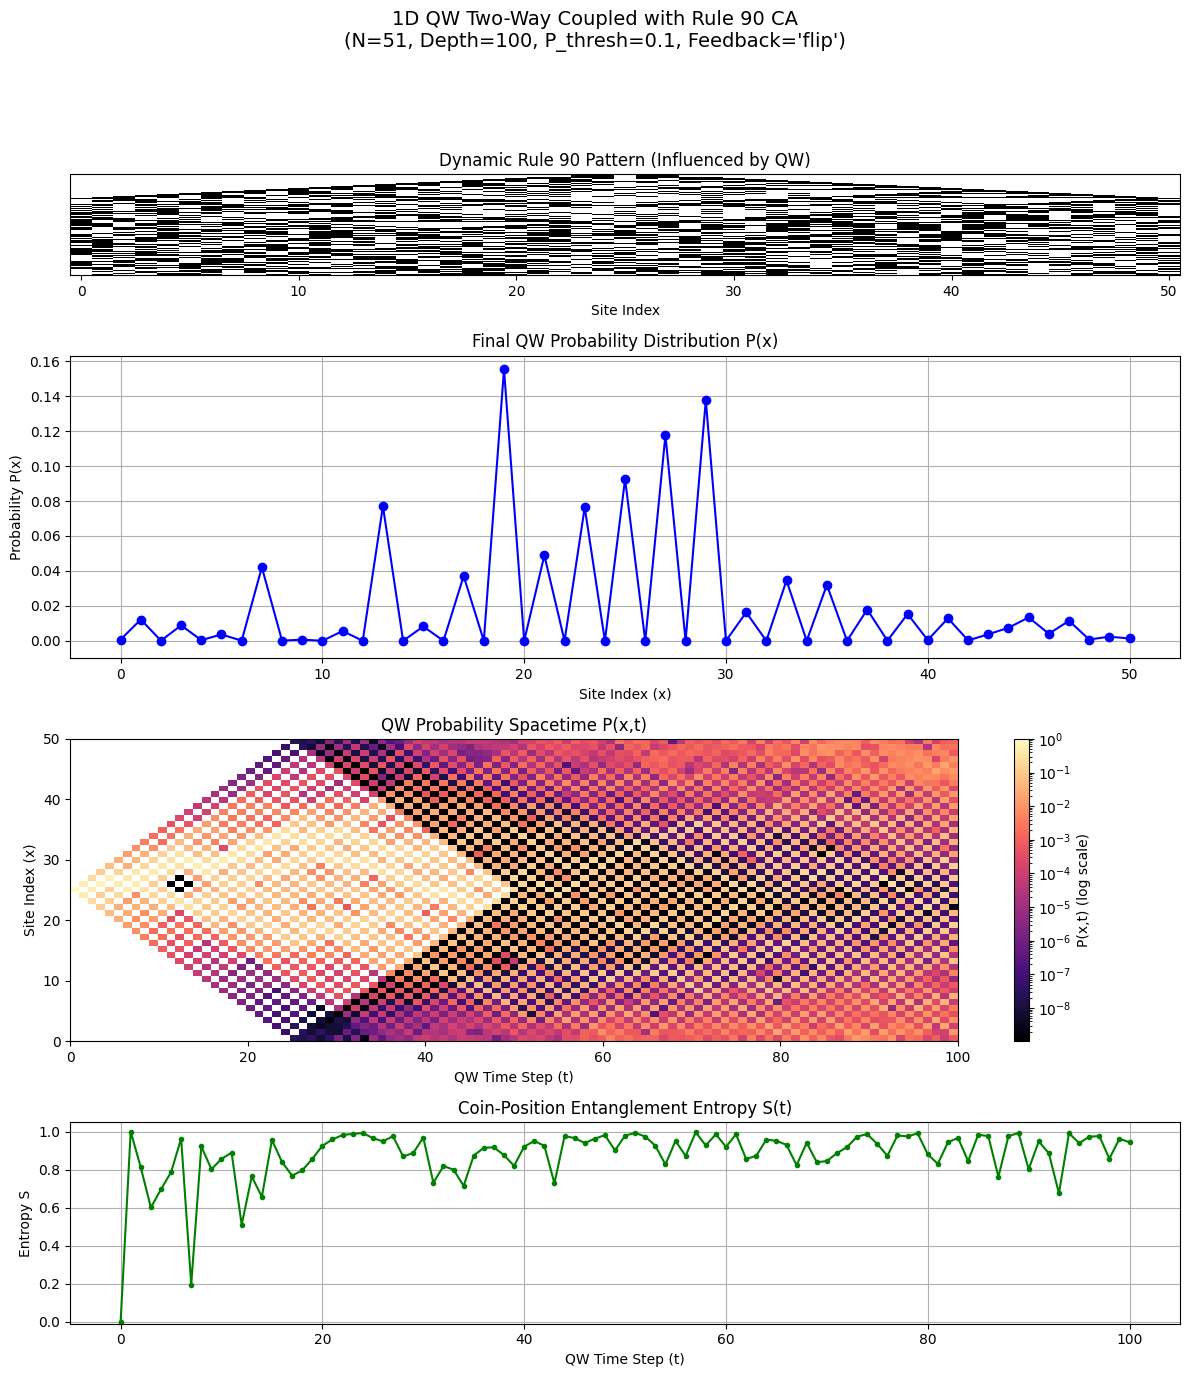

===== Finished 1D QW with Two-Way Coupled Rule 90 =====

===== Starting 1D Quantum Walk with TWO-WAY COUPLING to Rule 110 =====
Initialized 1D walker at site 25 in coin state |0> (index 50)

Starting 1D QW (Two-Way Coupled Rule 110 Coin, P_thresh=0.1, Feedback='flip') for 100 steps...
  Completed step 10/100
  Completed step 20/100
  Completed step 30/100
  Completed step 40/100
  Completed step 50/100
  Completed step 60/100
  Completed step 70/100
  Completed step 80/100
  Completed step 90/100
  Completed step 100/100
Evolution complete. Time: 0.20 seconds.

--- 1D QW (Two-Way Coupled Rule 110, P_thresh=0.1, Feedback='flip') Summary ---
N_sites=51, Depth=100, StartPos=25, StartCoin=0

Top 5 Final Probabilities (Site: Prob):
  Site 19: 0.14739
  Site 17: 0.10396
  Site 9: 0.09128
  Site 21: 0.07983
  Site 11: 0.07847

Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 50: S = 0.899920
  Step 100: S = 0.967702
--- End of Summary ---


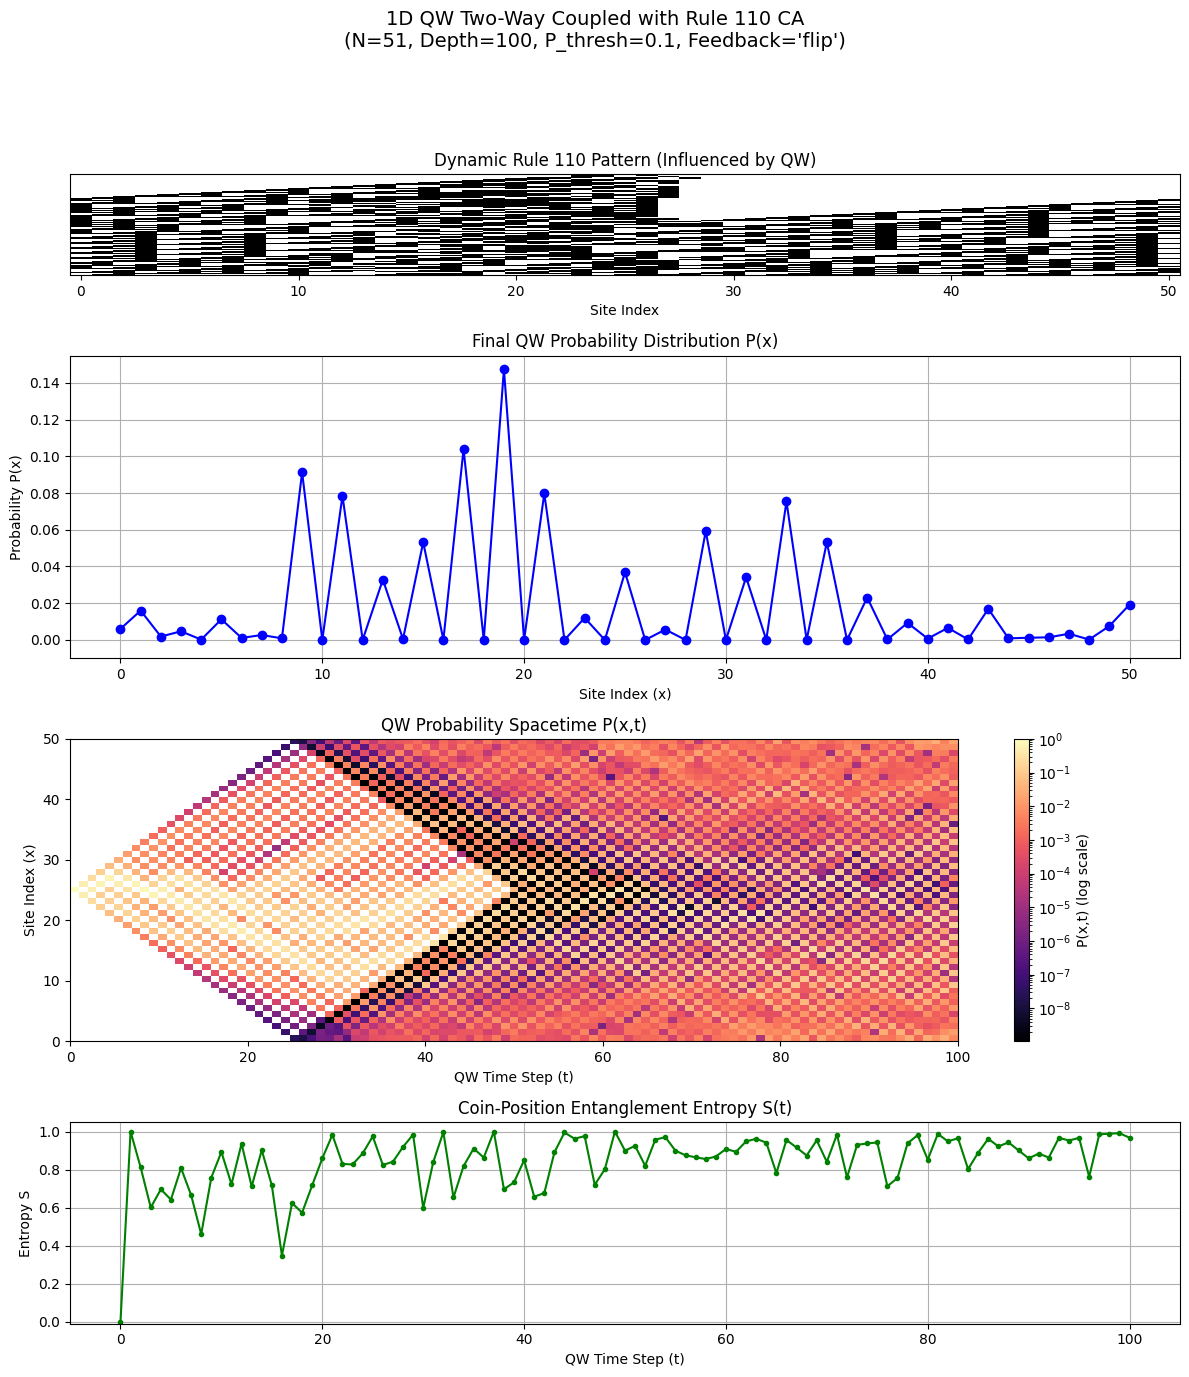

===== Finished 1D QW with Two-Way Coupled Rule 110 =====

===== Starting 1D Quantum Walk with TWO-WAY COUPLING to Rule 30 =====
Initialized 1D walker at site 25 in coin state |0> (index 50)

Starting 1D QW (Two-Way Coupled Rule 30 Coin, P_thresh=0.1, Feedback='flip') for 100 steps...
  Completed step 10/100
  Completed step 20/100
  Completed step 30/100
  Completed step 40/100
  Completed step 50/100
  Completed step 60/100
  Completed step 70/100
  Completed step 80/100
  Completed step 90/100
  Completed step 100/100
Evolution complete. Time: 0.23 seconds.

--- 1D QW (Two-Way Coupled Rule 30, P_thresh=0.1, Feedback='flip') Summary ---
N_sites=51, Depth=100, StartPos=25, StartCoin=0

Top 5 Final Probabilities (Site: Prob):
  Site 25: 0.15961
  Site 29: 0.11124
  Site 27: 0.10640
  Site 33: 0.10034
  Site 43: 0.09344

Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 50: S = 0.803458
  Step 100: S = 0.945595
--- End of Summary ---


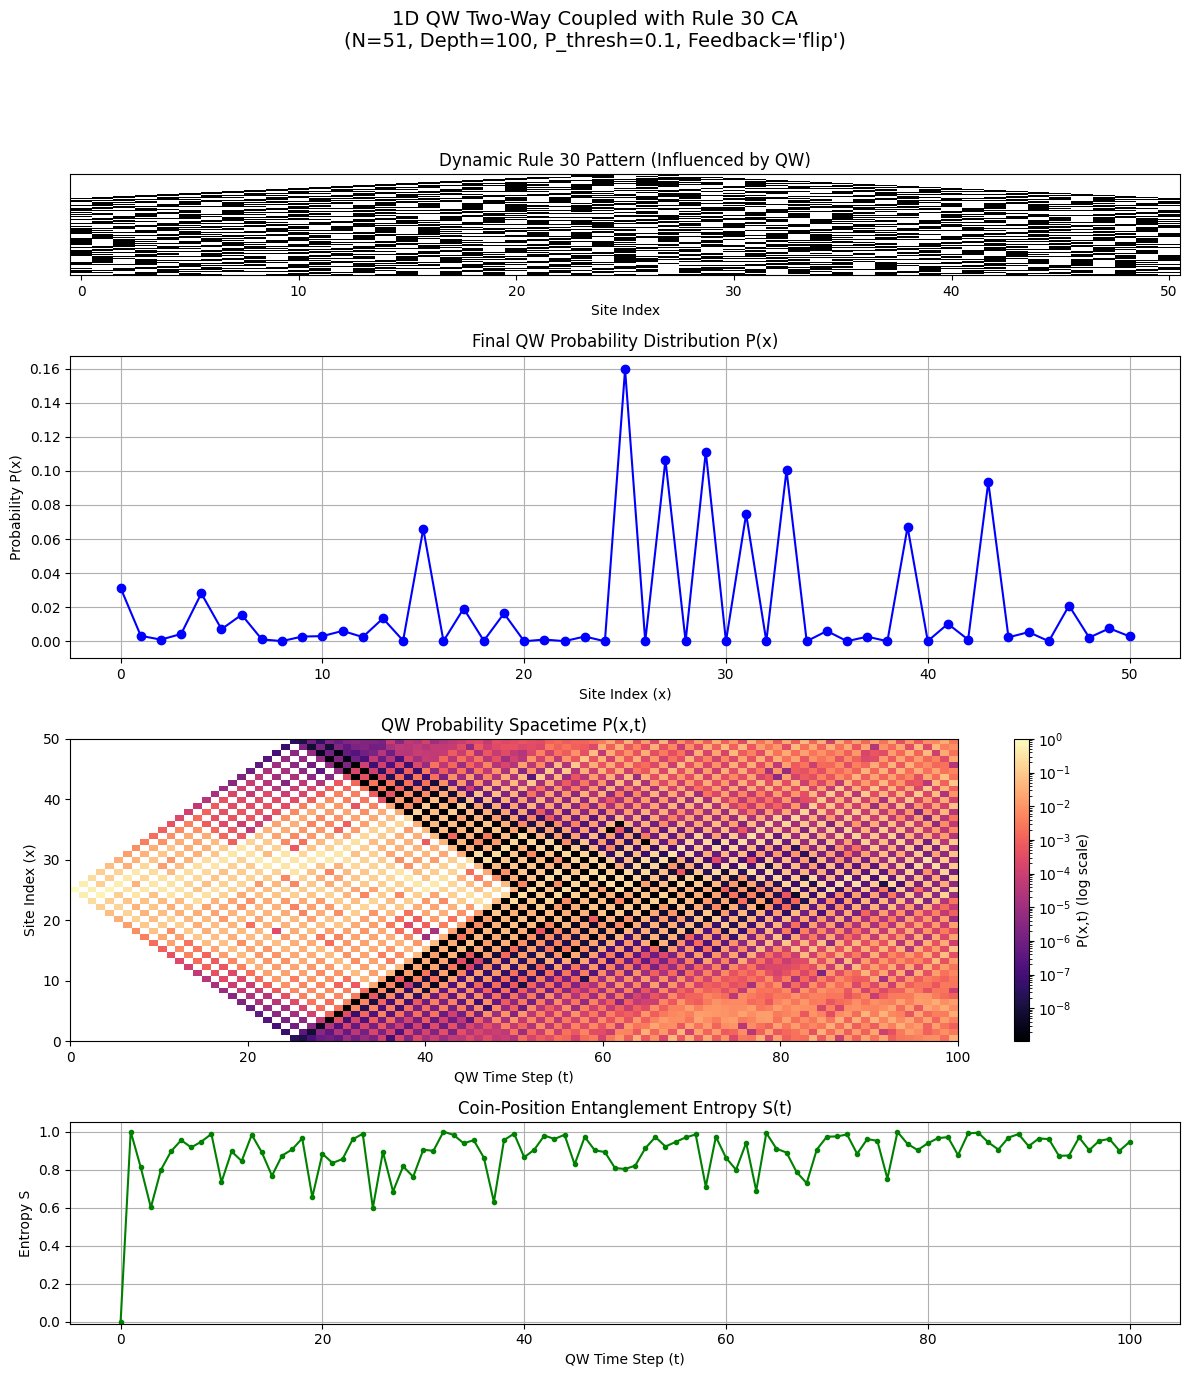

===== Finished 1D QW with Two-Way Coupled Rule 30 =====


<<<<< ALL SIMULATION SUMMARIES (Rule 90, 110, 30 - Two-Way Coupled) >>>>>

--- 1D QW (Two-Way Coupled Rule 90, P_thresh=0.1, Feedback='flip') Summary ---
N_sites=51, Depth=100, StartPos=25, StartCoin=0

Top 5 Final Probabilities (Site: Prob):
  Site 19: 0.15536
  Site 29: 0.13771
  Site 27: 0.11769
  Site 25: 0.09257
  Site 13: 0.07708

Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 50: S = 0.978343
  Step 100: S = 0.943859
--- End of Summary ---

--- 1D QW (Two-Way Coupled Rule 110, P_thresh=0.1, Feedback='flip') Summary ---
N_sites=51, Depth=100, StartPos=25, StartCoin=0

Top 5 Final Probabilities (Site: Prob):
  Site 19: 0.14739
  Site 17: 0.10396
  Site 9: 0.09128
  Site 21: 0.07983
  Site 11: 0.07847

Coin-Position Entanglement vs. Time:
  Step 0: S = 0.000000
  Step 50: S = 0.899920
  Step 100: S = 0.967702
--- End of Summary ---

--- 1D QW (Two-Way Coupled Rule 30, P_thresh=0.1, Feedback='flip') Summar

In [3]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

# --- Parameters ---
N_SITES_1D = 51
DEPTH_1D = 100 # Keep depth at 100 for these comparative runs
INITIAL_POS_1D = N_SITES_1D // 2
INITIAL_COIN_1D = 0
INITIAL_CA_CENTER_ONE = True

# --- Two-Way Coupling Parameters ---
P_THRESHOLD = 0.1
FEEDBACK_TYPE = "flip"

# --- CA Rule Update Function ---
def update_ca_line(current_line, rule_number):
    width = len(current_line)
    new_line = np.zeros(width, dtype=int)
    for i in range(width):
        prev_left = current_line[(i - 1 + width) % width]
        prev_center = current_line[i]
        prev_right = current_line[(i + 1) % width]
        pattern_val = (prev_left << 2) | (prev_center << 1) | prev_right
        if rule_number == 30:
            if pattern_val in [1, 2, 3, 4]: new_line[i] = 1
            else: new_line[i] = 0
        elif rule_number == 90: # L_prev XOR R_prev
            if prev_left != prev_right: new_line[i] = 1
            else: new_line[i] = 0
        elif rule_number == 110:
            if pattern_val in [1, 2, 3, 5, 6]: new_line[i] = 1 # 001,010,011,101,110
            else: new_line[i] = 0
        else: raise ValueError(f"Rule {rule_number} not implemented.")
    return new_line

# --- Coin Matrices (1-Qubit Coin) ---
H_1Q = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=np.complex128)
X_1Q = np.array([[0,1],[1,0]], dtype=np.complex128)
COIN_OP_CA_ZERO = H_1Q
COIN_OP_CA_ONE  = X_1Q @ H_1Q

# --- Helper Functions (1D QW) ---
def get_1d_index(coin_val, site_pos, n_sites_1d):
    if not (0 <= site_pos < n_sites_1d and 0 <= coin_val <= 1):
        raise IndexError(f"Invalid coin ({coin_val}) or pos ({site_pos}) for 1D index (N_sites={n_sites_1d})")
    return coin_val + 2 * site_pos

def get_1d_coin_pos_from_index(k, n_sites_1d):
    state_dim_1d = 2 * n_sites_1d
    if not (0 <= k < state_dim_1d):
        raise IndexError(f"Invalid k ({k}) for 1D coin/pos (StateDim={state_dim_1d})")
    coin_val = k % 2
    site_pos = k // 2
    return coin_val, site_pos

# --- Initial State Preparation (1D QW) ---
def prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val=0):
    state_dim_1d = 2 * n_sites_1d
    initial_state_vector = np.zeros(state_dim_1d, dtype=np.complex128)
    try:
        start_index = get_1d_index(initial_coin_val, initial_pos, n_sites_1d)
        initial_state_vector[start_index] = 1.0
        print(f"Initialized 1D walker at site {initial_pos} in coin state |{initial_coin_val}> (index {start_index})")
    except IndexError as e:
        print(f"Error during 1D initial state prep: {e}")
    return initial_state_vector

# --- Build QW Step Operator ---
def build_1d_qw_step_operator(n_sites_1d, current_ca_pattern, coin0_op, coin1_op):
    state_dim_1d = 2 * n_sites_1d
    C_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for site_idx in range(n_sites_1d):
        chosen_coin_op = coin0_op if current_ca_pattern[site_idx] == 0 else coin1_op
        idx_s_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_s_c1 = get_1d_index(1, site_idx, n_sites_1d)
        C_full[idx_s_c0, idx_s_c0] = chosen_coin_op[0,0]
        C_full[idx_s_c1, idx_s_c0] = chosen_coin_op[1,0]
        C_full[idx_s_c0, idx_s_c1] = chosen_coin_op[0,1]
        C_full[idx_s_c1, idx_s_c1] = chosen_coin_op[1,1]
    S_full = np.zeros((state_dim_1d, state_dim_1d), dtype=np.complex128)
    for k_in in range(state_dim_1d):
        coin_val, site_pos = get_1d_coin_pos_from_index(k_in, n_sites_1d)
        new_pos = site_pos
        if coin_val == 0:
            new_pos = (site_pos - 1 + n_sites_1d) % n_sites_1d
        else:
            new_pos = (site_pos + 1) % n_sites_1d
        k_out = get_1d_index(coin_val, new_pos, n_sites_1d)
        S_full[k_out, k_in] = 1.0
    U_step = S_full @ C_full
    return U_step

# --- Observables (1D QW) ---
def calculate_p1_position_1d(state_vector, n_sites_1d):
    prob_dist_1d = np.zeros(n_sites_1d)
    for site_idx in range(n_sites_1d):
        idx_c0 = get_1d_index(0, site_idx, n_sites_1d)
        idx_c1 = get_1d_index(1, site_idx, n_sites_1d)
        prob_dist_1d[site_idx] = np.abs(state_vector[idx_c0])**2 + np.abs(state_vector[idx_c1])**2
    return prob_dist_1d

def calculate_coin_position_entanglement_1d(state_vector, n_sites_1d):
    coin_dim = 2
    state_dim_1d = coin_dim * n_sites_1d
    if len(state_vector) != state_dim_1d: return np.nan
    norm = np.linalg.norm(state_vector)
    if np.abs(norm - 1.0) > 1e-6:
        if norm < 1e-9: return 0.0
        state_vector = state_vector / norm
        if np.isnan(state_vector).any(): return np.nan
    try:
        rho_full_matrix = np.outer(state_vector, np.conjugate(state_vector))
        rho_coin = np.zeros((coin_dim, coin_dim), dtype=np.complex128)
        for site_idx in range(n_sites_1d):
            for c_row in range(coin_dim):
                 for c_col in range(coin_dim):
                      k_row = get_1d_index(c_row, site_idx, n_sites_1d)
                      k_col = get_1d_index(c_col, site_idx, n_sites_1d)
                      rho_coin[c_row, c_col] += rho_full_matrix[k_row, k_col]
        trace_rho_coin = np.trace(rho_coin)
        if np.abs(trace_rho_coin - 1.0) > 1e-6:
            if abs(trace_rho_coin) > 1e-9: rho_coin /= trace_rho_coin
        eigenvalues = np.linalg.eigvalsh(rho_coin)
        entropy = 0.0; epsilon = 1e-12
        for eig_val in eigenvalues:
            if eig_val > epsilon:
                try: entropy -= eig_val * np.log2(eig_val)
                except ValueError: pass
        return max(0.0, np.real(entropy))
    except Exception as e:
        print(f"Error calculating 1D coin-position entanglement: {e}")
        return np.nan

# --- Simulation Loop (1D QW with Two-Way Coupled Dynamic CA Coin) ---
def run_1d_qw_two_way_coupling(
    n_sites_1d, depth, initial_pos, initial_coin_val,
    initial_ca_center_one, ca_rule_number, coin0_op, coin1_op,
    p_threshold, feedback_type
):
    current_qw_state = prepare_initial_state_1d(n_sites_1d, initial_pos, initial_coin_val)
    current_ca_line = np.zeros(n_sites_1d, dtype=int)
    if initial_ca_center_one and n_sites_1d > 0:
        if n_sites_1d % 2 == 1: current_ca_line[n_sites_1d // 2] = 1
        else: current_ca_line[n_sites_1d // 2 -1] = 1

    prob_history_1d = [calculate_p1_position_1d(current_qw_state, n_sites_1d)]
    ent_history_1d = [calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d)]
    ca_history = [current_ca_line.copy()]

    print(f"\nStarting 1D QW (Two-Way Coupled Rule {ca_rule_number} Coin, P_thresh={p_threshold}, Feedback='{feedback_type}') for {depth} steps...")
    start_time = time.time()
    for step in range(depth):
        U_step = build_1d_qw_step_operator(n_sites_1d, current_ca_line, coin0_op, coin1_op)
        current_qw_state = U_step @ current_qw_state
        norm_qw = np.linalg.norm(current_qw_state)
        if abs(norm_qw) > 1e-9 : current_qw_state /= norm_qw
        else: print(f"Warning: QW State norm zero at step {step+1}"); break

        qw_probs_at_sites = calculate_p1_position_1d(current_qw_state, n_sites_1d)
        ca_line_for_next_update = current_ca_line.copy()

        for site_idx in range(n_sites_1d):
            if qw_probs_at_sites[site_idx] > p_threshold:
                if feedback_type == "flip":
                    ca_line_for_next_update[site_idx] = 1 - ca_line_for_next_update[site_idx]
                elif feedback_type == "set_to_one":
                    ca_line_for_next_update[site_idx] = 1
                elif feedback_type == "set_to_zero":
                    ca_line_for_next_update[site_idx] = 0

        current_ca_line = update_ca_line(ca_line_for_next_update, ca_rule_number)

        prob_history_1d.append(qw_probs_at_sites)
        ent_history_1d.append(calculate_coin_position_entanglement_1d(current_qw_state, n_sites_1d))
        ca_history.append(current_ca_line.copy())

        if (step + 1) % (depth // 10 if depth >=10 else 1) == 0 :
            print(f"  Completed step {step + 1}/{depth}")
    end_time = time.time()
    print(f"Evolution complete. Time: {end_time - start_time:.2f} seconds.")

    return {
        "prob_history": np.array(prob_history_1d),
        "ent_history": np.array(ent_history_1d),
        "ca_history": np.array(ca_history),
        "params": {
            "n_sites": n_sites_1d, "depth": depth,
            "initial_pos": initial_pos, "initial_coin": initial_coin_val,
            "initial_ca_center_one": initial_ca_center_one,
            "ca_rule_number": ca_rule_number,
            "p_threshold": p_threshold,
            "feedback_type": feedback_type
        }
    }

# --- Plotting and Summary (1D QW with Dynamic CA and Two-Way Coupling) ---
def plot_1d_qw_results_two_way(results):
    params = results["params"]; prob_hist = results["prob_history"]
    ent_hist = results["ent_history"]; ca_hist = results["ca_history"]
    depth = params['depth']; ca_rule_number = params['ca_rule_number']
    p_thresh = params['p_threshold']; feedback = params['feedback_type']

    fig, axs = plt.subplots(4, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 3, 3, 2]})
    title = (f"1D QW Two-Way Coupled with Rule {ca_rule_number} CA\n"
             f"(N={params['n_sites']}, Depth={depth}, P_thresh={p_thresh}, Feedback='{feedback}')")
    fig.suptitle(title, fontsize=14)

    axs[0].imshow(ca_hist, cmap='binary', aspect='auto', interpolation='nearest')
    axs[0].set_title(f"Dynamic Rule {ca_rule_number} Pattern (Influenced by QW)")
    axs[0].set_xlabel("Site Index"); axs[0].set_yticks([])

    axs[1].plot(np.arange(params['n_sites']), prob_hist[-1, :], marker='o', linestyle='-', color='blue')
    axs[1].set_title("Final QW Probability Distribution P(x)")
    axs[1].set_xlabel("Site Index (x)"); axs[1].set_ylabel("Probability P(x)")
    axs[1].grid(True); axs[1].set_ylim(bottom=-0.01)

    prob_spacetime = prob_hist.T
    pos_probs = prob_spacetime[prob_spacetime > 1e-9]
    min_val = pos_probs.min() if len(pos_probs) > 0 else 1e-9
    max_val = prob_spacetime.max()
    norm_val = colors.LogNorm(vmin=min_val, vmax=max(max_val, min_val + 1e-6))
    im = axs[2].imshow(prob_spacetime, aspect='auto', origin='lower', cmap='magma', norm=norm_val,
                       extent=[0, depth, 0, params['n_sites']-1])
    plt.colorbar(im, ax=axs[2], label="P(x,t) (log scale)")
    axs[2].set_title("QW Probability Spacetime P(x,t)")
    axs[2].set_xlabel("QW Time Step (t)"); axs[2].set_ylabel("Site Index (x)")

    time_steps_qw = np.arange(depth + 1)
    axs[3].plot(time_steps_qw, ent_hist, marker='.', linestyle='-', color='green')
    axs[3].set_title("Coin-Position Entanglement Entropy S(t)")
    axs[3].set_xlabel("QW Time Step (t)"); axs[3].set_ylabel("Entropy S")
    axs[3].grid(True); axs[3].set_ylim(bottom=-0.01, top=1.05)

    plt.tight_layout(rect=[0, 0, 1, 0.93]); plt.show()

def generate_1d_qw_text_output_two_way(results):
    params = results["params"]; prob_hist = results["prob_history"]; ent_hist = results["ent_history"]
    ca_rule_number = params['ca_rule_number']
    p_thresh = params['p_threshold']; feedback = params['feedback_type']

    output_lines = [f"\n--- 1D QW (Two-Way Coupled Rule {ca_rule_number}, P_thresh={p_thresh}, Feedback='{feedback}') Summary ---"]
    output_lines.append(f"N_sites={params['n_sites']}, Depth={params['depth']}, StartPos={params['initial_pos']}, StartCoin={params['initial_coin']}")

    output_lines.append("\nTop 5 Final Probabilities (Site: Prob):")
    final_probs = prob_hist[-1, :]
    sorted_indices = np.argsort(final_probs)[::-1]
    for i in range(min(5, params['n_sites'])):
        idx = sorted_indices[i]
        output_lines.append(f"  Site {idx}: {final_probs[idx]:.5f}")

    output_lines.append("\nCoin-Position Entanglement vs. Time:")
    num_steps_total = len(ent_hist)
    indices_to_show = [0]
    if num_steps_total > 2: indices_to_show.append(num_steps_total // 2)
    if num_steps_total > 1: indices_to_show.append(num_steps_total - 1)
    indices_to_show = sorted(list(set(indices_to_show)))
    for idx in indices_to_show:
        s_val_str = f"{ent_hist[idx]:.6f}" if np.isfinite(ent_hist[idx]) else "nan"
        output_lines.append(f"  Step {idx}: S = {s_val_str}")
    output_lines.append("--- End of Summary ---")
    return "\n".join(output_lines)


# --- Main Execution (1D QW) ---
if __name__ == "__main__":

    rules_to_test = [90, 110, 30]

    all_results_text = []

    for rule_num in rules_to_test:
        print(f"\n===== Starting 1D Quantum Walk with TWO-WAY COUPLING to Rule {rule_num} =====")

        results_1d_two_way = run_1d_qw_two_way_coupling(
            n_sites_1d=N_SITES_1D,
            depth=DEPTH_1D,
            initial_pos=INITIAL_POS_1D,
            initial_coin_val=INITIAL_COIN_1D,
            initial_ca_center_one=INITIAL_CA_CENTER_ONE,
            ca_rule_number=rule_num,
            coin0_op=COIN_OP_CA_ZERO,
            coin1_op=COIN_OP_CA_ONE,
            p_threshold=P_THRESHOLD,
            feedback_type=FEEDBACK_TYPE
        )

        text_summary = generate_1d_qw_text_output_two_way(results_1d_two_way)
        all_results_text.append(text_summary)
        print(text_summary)

        plot_1d_qw_results_two_way(results_1d_two_way)
        print(f"===== Finished 1D QW with Two-Way Coupled Rule {rule_num} =====")

    print("\n\n<<<<< ALL SIMULATION SUMMARIES (Rule 90, 110, 30 - Two-Way Coupled) >>>>>")
    for summary in all_results_text:
        print(summary)
    print("<<<<< END OF ALL SIMULATION SUMMARIES >>>>>")

These experiments beautifully demonstrate the richness that arises from even a simple form of two-way coupling between a quantum system and a classical, rule-based environment.
Emergent "Physics": The "rules of movement" for the QW are no longer static; they are dynamically generated by the CA, which is, in turn, modified by the QW. This is a primitive form of a system defining its own "laws" through interaction.
Structure Formation: The QW carves structures (paths, clearings) in the CA. These structures then act as effective potentials or guides for the QW. This self-organizing behavior is very interesting.
Sensitivity to Rules: The distinct differences in the QW's behavior under CA Rules 90, 110, and 30 (even with the same feedback mechanism) show that the "fundamental rules" of the environment have a profound impact on the emergent quantum dynamics.
Computational Power: Rule 110 is Turing complete. The QW interacting with it is exploring a computationally powerful environment. The fact that the QW can influence this environment opens up possibilities for thinking about how quantum processes might interact with or even drive classical computation, and vice-versa.
This is a fantastic step towards simulating more complex "computational universe" models where particles and spacetime (or the underlying rule structure) are not separate but dynamically influence each other.